In [5]:
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

def get_precision_recall(labels, scores):
    num_pos = np.sum(labels == 1)
    num_neg = labels.shape[0] - num_pos
    precision, recall, thr = precision_recall_curve(labels, scores, pos_label=1)
    # auprc = auc(recall, precision)
    recall_neg = (1.0 - precision) * (recall * num_pos / precision) / num_neg
    return (precision, recall, thr, recall_neg)


def plot_prc(precision, recall, thr, recall_neg, get_label, ax, legend):
    ax.plot(recall, precision)
    ax.set_xlim(0.0, 1.0)
    # ax.set_ylim(0.0, 1.0)

    scatter_x, scatter_y = [], []
    last_recall = 1.0
    gap = (recall[0] - recall[-1]) / 20
    for x, y, threshold, pn in zip(recall, precision, thr, recall_neg):
        if last_recall - x >= gap * 2 or last_recall - x >= gap and x >= recall[0] * 0.9:
            ax.annotate(get_label(threshold),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')
            '''
            ax.annotate("{:.2f}".format(pn),
                         (x,y),
                         textcoords="offset points",
                         xytext=(0,-18),
                         ha='center')
            '''
            scatter_x.append(x)
            scatter_y.append(y)
            last_recall = x

    ax.scatter(scatter_x, scatter_y)

    """
    font = FontProperties()
    font.set_family("monospace")
    font.set_size(14)
    ax.text(0.03, 0.13, legend,
            transform=ax.transAxes, fontproperties=font,
            verticalalignment='top', bbox=dict(alpha=0.3));
    """
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='1.0',)
    ax.grid(which='minor', linestyle=':', linewidth='1.0',);


def plot_edit_rescue(data, label):
    _, labels, scores, _ = data
    edit_rate = (len(labels) - np.sum(labels)) / len(labels) * 100.0
    total = len(labels)
    num_good = np.sum(labels)
    num_bad = total - num_good

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    precision, recall, thr, recall_neg = get_precision_recall(labels, scores)
    cali_recall = recall / precision * (num_good / total)
    plot_prc(precision, cali_recall, thr, recall_neg, lambda v: ">{:.2e}".format(v), ax[0],
            '>9.99e-01  Threshold\n 0.02  BL(Ɵ)/B')
    ax[0].set_title("Filter good examples in " + label + ", edit rate: {:.2f}%".format(edit_rate))
    ax[0].set_xlabel("L(Ɵ)/(B+G)")
    ax[0].set_ylabel("GL(Ɵ)/L(Ɵ)")
    ret1 = (precision, cali_recall, thr)

    precision, recall, thr, recall_neg = get_precision_recall(1.0 - labels, 1.0 - scores)
    cali_recall = recall / precision * (num_bad / total)
    lim = np.argmax(precision >= 0.50)
    plot_prc(precision[lim:], cali_recall[lim:], thr[lim:], recall_neg[lim:],
             lambda v: "<{:.2e}".format(1.0 - v), ax[1], '<1.72e-1  Threshold Ɵ\n 0.02  GS(Ɵ)/G')
    ax[1].set_xlim(cali_recall[-1], cali_recall[lim])
    ax[1].set_ylim(precision[lim], precision[-1])
    ax[1].set_yscale("log")
    ax[1].set_xlabel("S(Ɵ)/(B+G)")
    ax[1].set_ylabel("BS(Ɵ)/S(Ɵ)")
    ax[1].set_title("Filter bad examples in " + label + ", edit rate: {:.2f}%".format(edit_rate))
    ret2 = (precision, cali_recall, thr)

    fig.tight_layout();
    return (ret1, ret2)

In [2]:
base_dir = "../chulk-logs/runtime_scores"
_style = ['b', 'r']
sources = ['AGSO', 'JAMSTEC', 'JAMSTEC2', 'NGA', 'NGA2', 'NGDC', 'NOAA_geodas', 'SIO', 'US_multi']

## Explnation of recall-precision graph

The following graphs represent the performance of using different thresholds on the predicted scores on the precision and recall.

The meaning of precision and recall in different in editing and in rescuing.

## Basic quantities


Label: 0 is corrupt, 1 is good

We expect the bad examples receive the scores of small values, and the good examples receive the scores of
large values. Furthermore, we define following basic quantities.

* $BS(\theta)$: the # of bad examples that receive small scores when the threshold is $<\theta$.
* $GS(\theta)$: the # of good examples that receive large scores when the threshold is $<\theta$.
* $BL(\theta)$: the # of bad examples that receive large scores when the threshold is $>\theta$.
* $GL(\theta)$: the # of good examples that receive large scores when the threshold is $>\theta$.

In addition,

* $B$: the # of bad examples
* $G$: the # of good examples
* $S(\theta)$: the # of examples that receive a score smaller than $\theta$
* $G(\theta)$: the # of examples that receive a score larger than $\theta$


## Editing

In editing, we want to export the good examples. In this case, the X-axis is $GL(\theta)/G$ (recall),
and the Y-axis is $GL(\theta)/L(\theta)$ (precision).


## Rescuing

In rescue, we want to export the bad examples (then assume all that not exported are good).
In this case, the X-axis is $BS(\theta)/B$ (recall),
and the Y-axis is $BS(\theta)/S(\theta)$ (precision).

![](./d2.png)

AGSO, 

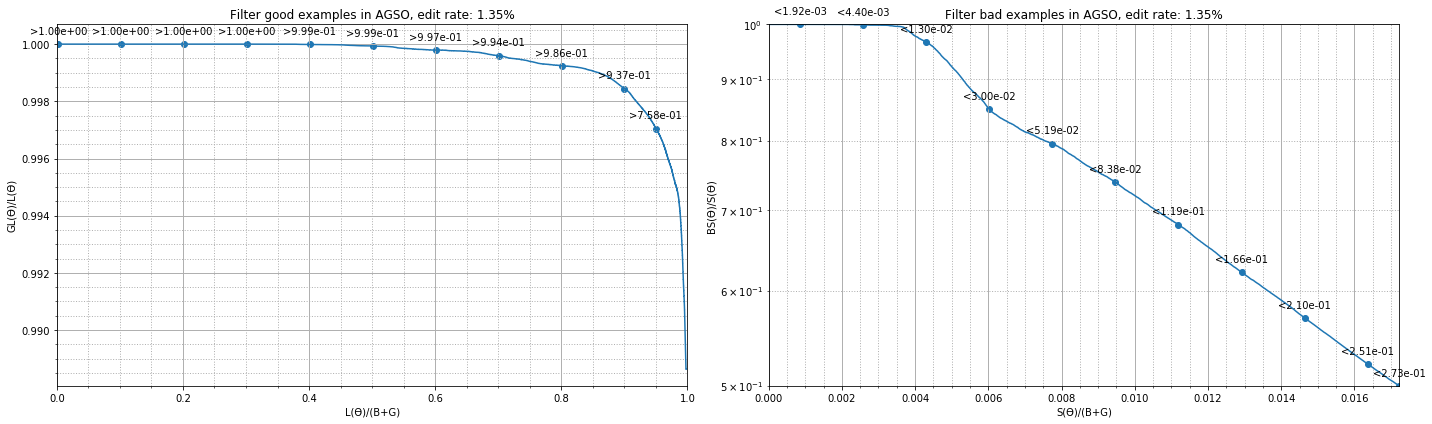

In [4]:
source = sources[0]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

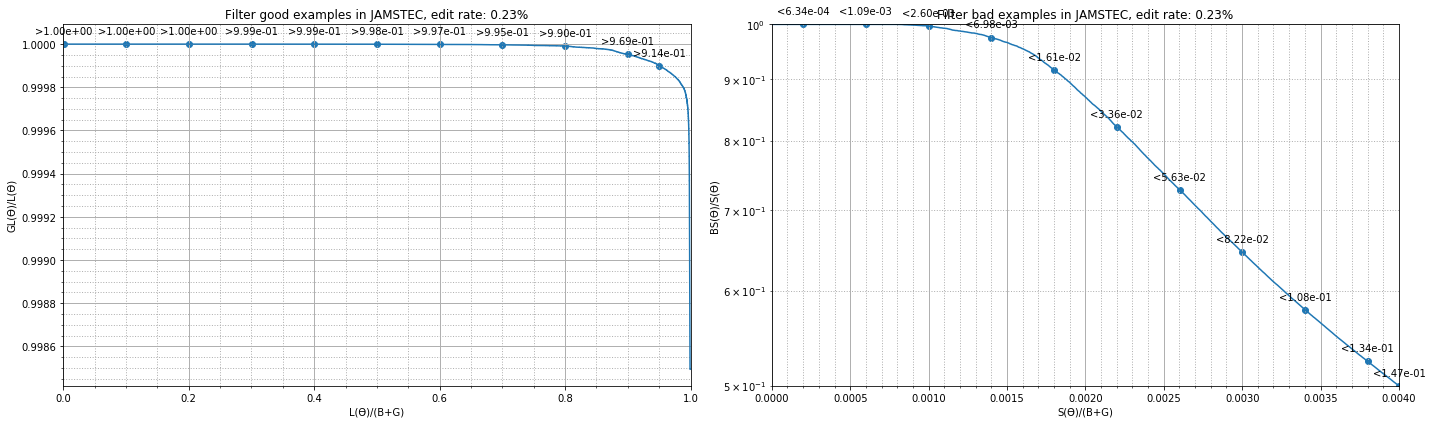

In [5]:
source = sources[1]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

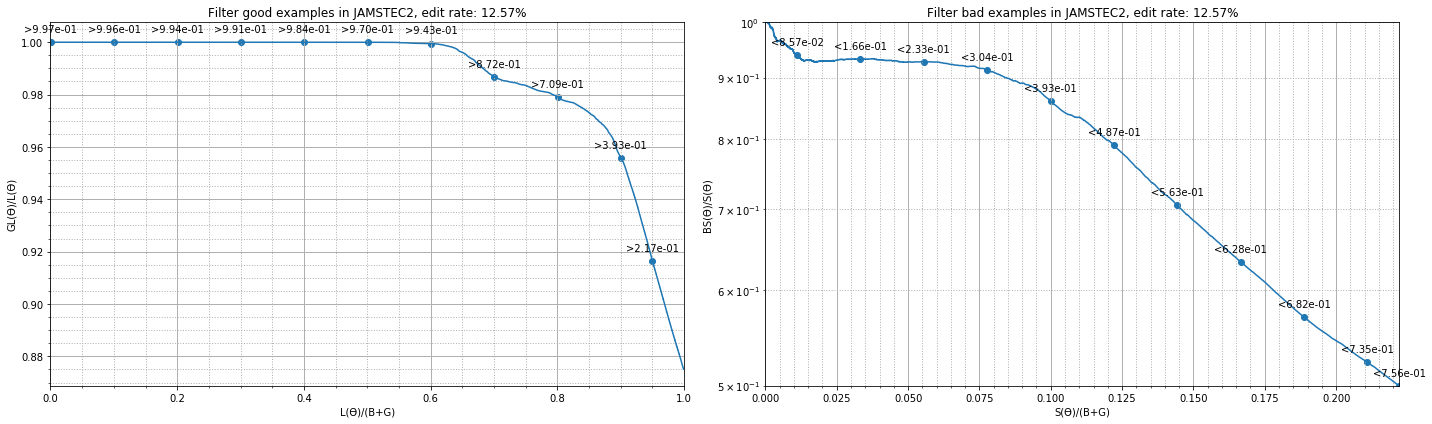

In [6]:
source = sources[2]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

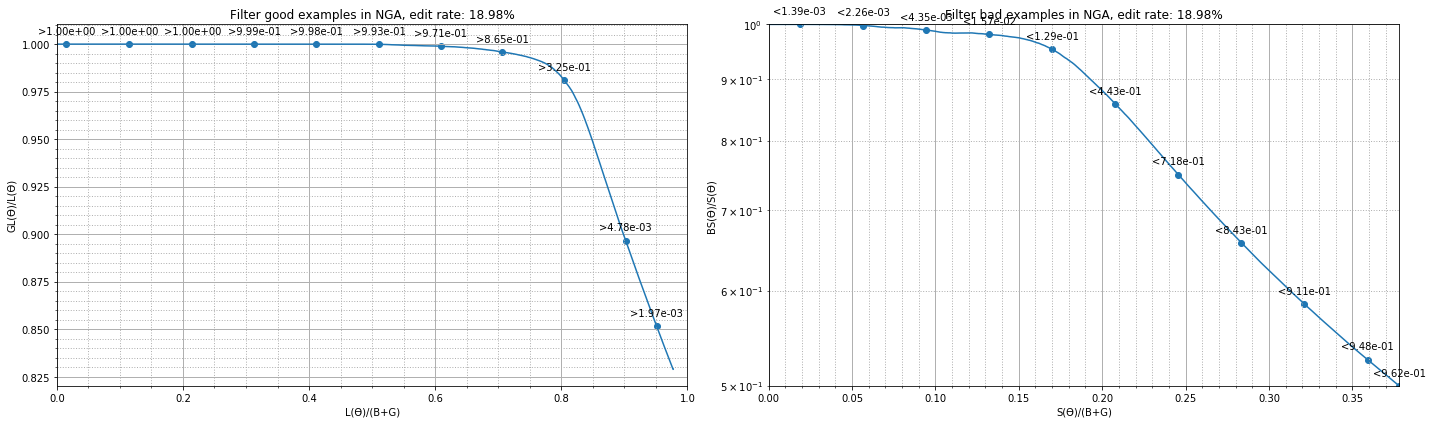

In [7]:
source = sources[3]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

In [30]:
ret1[0][7275], ret1[2][7275], np.argmax(ret1[0] >= 0.99998)

(0.9999806718897167, 0.7103345220803181, 7275)

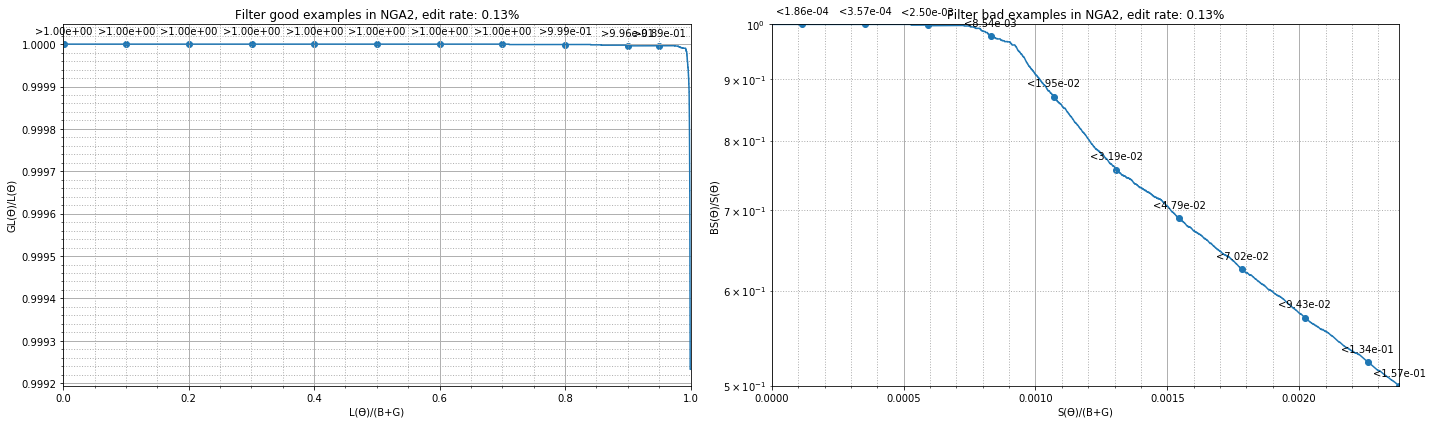

In [8]:
source = sources[4]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

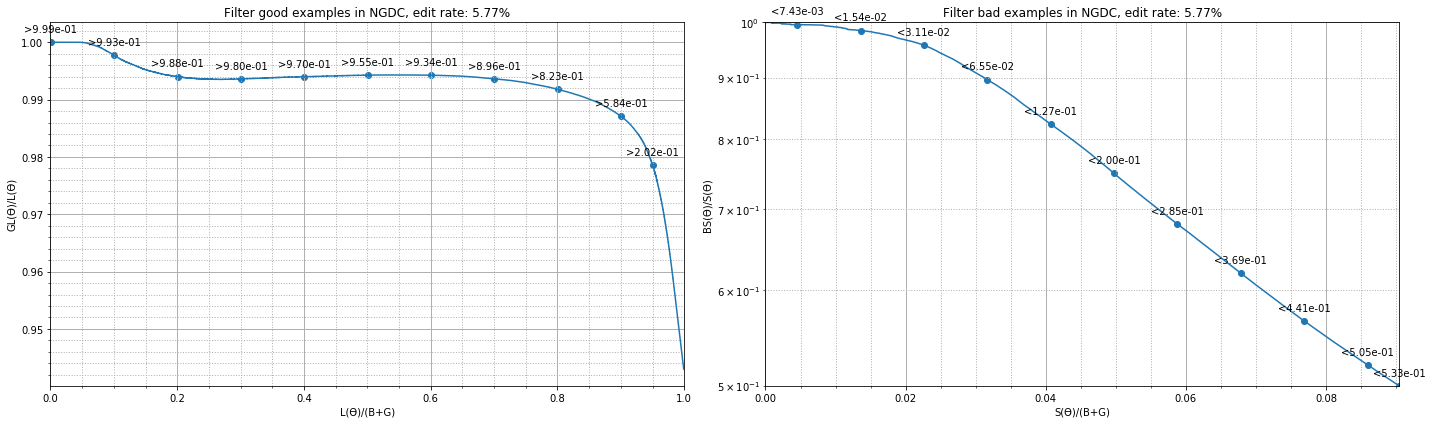

In [9]:
source = sources[5]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

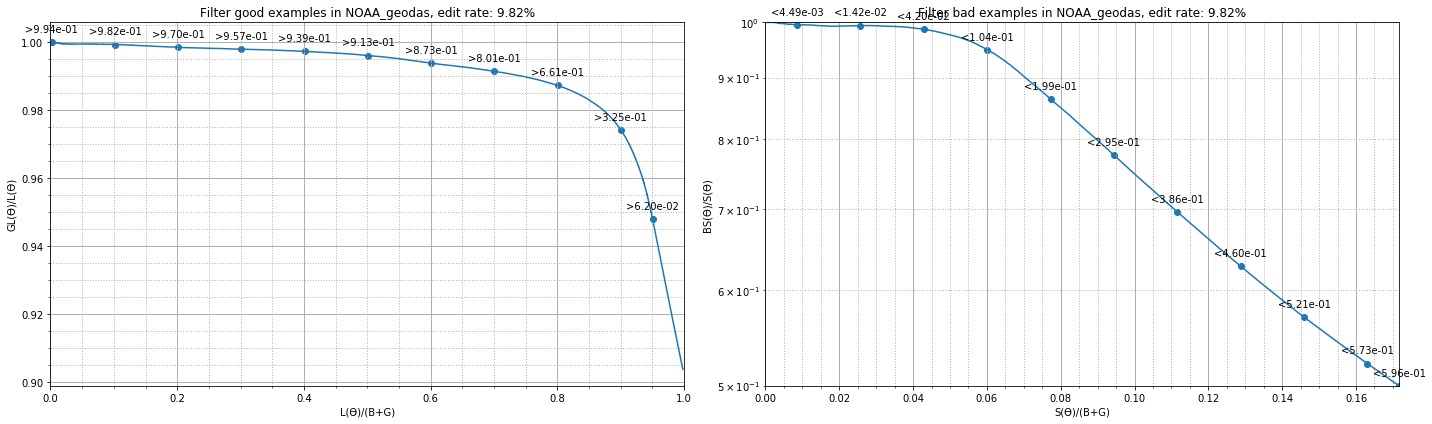

In [10]:
source = sources[6]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

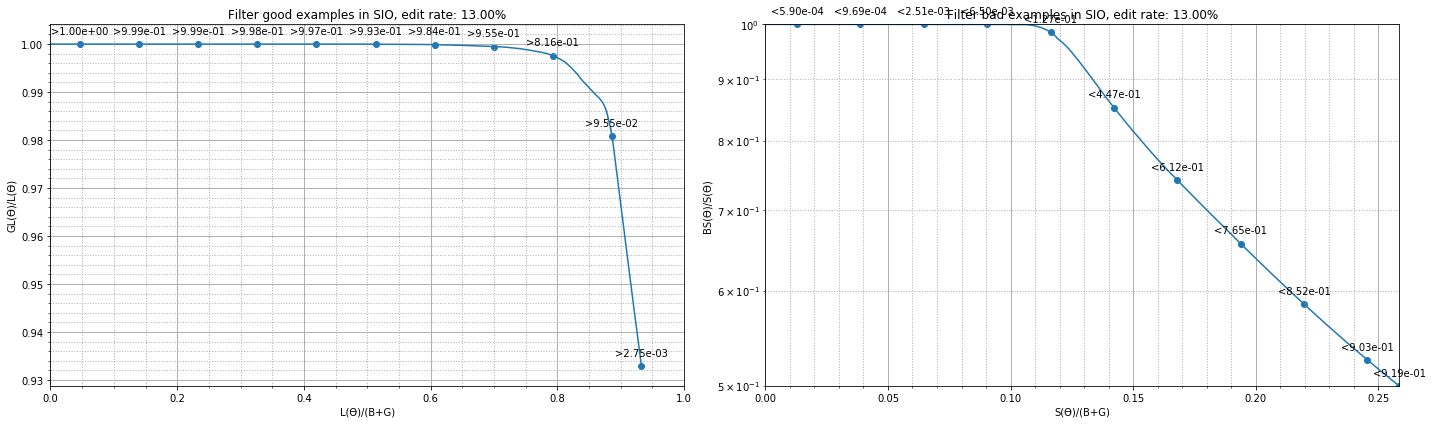

In [11]:
source = sources[7]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

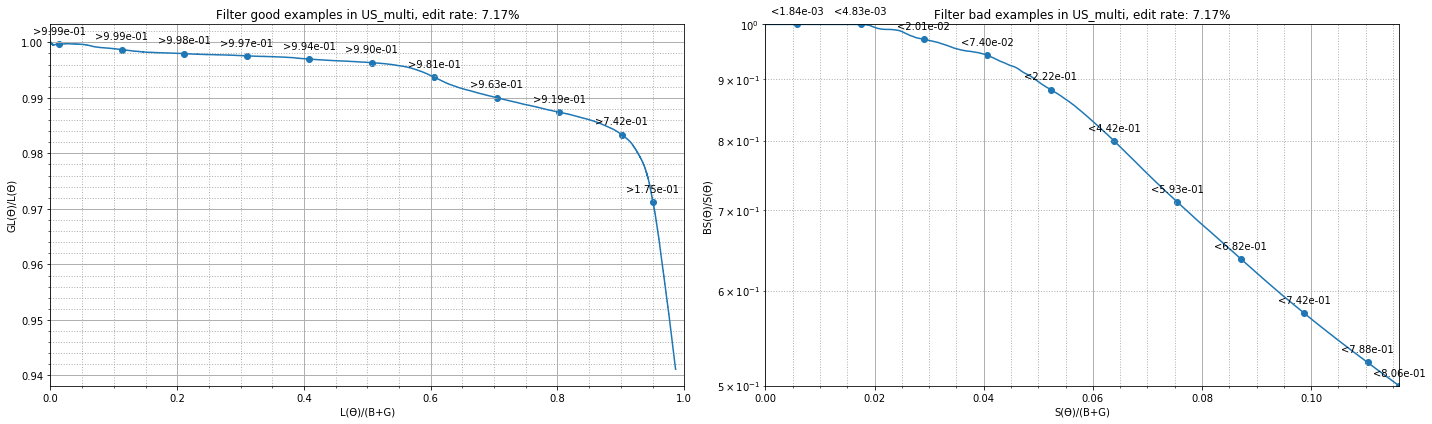

In [12]:
source = sources[8]
path = os.path.join(base_dir, "model_{0:}_test_{0:}_scores.pkl".format(source))
with open(path, 'rb') as f:
    data = pickle.load(f)
plot_edit_rescue(data, source)

In [18]:
import pandas as pd
import numpy as np
from io import StringIO
from os.path import expanduser

with open(expanduser("~/temp_all.txt")) as f:
    lines = [line.split(",") for line in f.readlines()]

regions = [line[0] for line in lines]
mat = [list(map(lambda t: float(t), line[1:])) for line in lines]
print(regions)

# Reorder

regions_mapping = {t: index for index, t in enumerate(regions)}
new_regions = ['AGSO', 'NOAA_geodas', 'NGA', 'NGA2', 'NGDC', 'JAMSTEC', 'JAMSTEC2', 'SIO', 'US_multi', 'all']

new_mat = []
for i, r1 in enumerate(new_regions):
    new_mat.append([0.0] * len(new_regions[:-1]))
    for j, r2 in enumerate(new_regions[:-1]):
        new_mat[i][j] = mat[regions_mapping[r1]][regions_mapping[r2]]

['AGSO', 'JAMSTEC', 'JAMSTEC2', 'NGA', 'NGA2', 'NGDC', 'NOAA_geodas', 'SIO', 'US_multi', 'all']


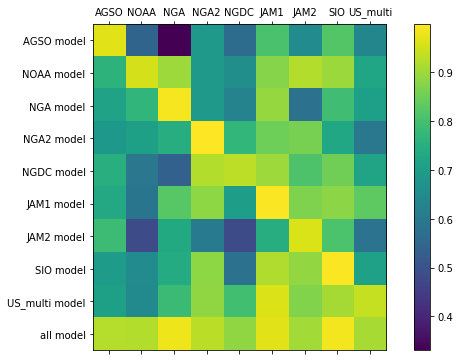

In [28]:
new_regions[1] = "NOAA"
new_regions[5] = "JAM1"
new_regions[6] = "JAM2"

from matplotlib import pyplot as plt

if True:
    THRESHOLD = 0.5
    mat = np.clip(new_mat, THRESHOLD, 1.0)

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(new_mat)
fig.colorbar(cax);

ax.set_yticks(np.arange(10))
ax.set_yticklabels([s + " model" for s in new_regions])
ax.set_xticklabels([''] + new_regions[:-1]);